## Multi-label prediction with Planet Amazon dataset

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
from fastai.vision import *
from PIL import Image as pimage

In [14]:
path = Config.data_path()/'bengali'
path.mkdir(parents=True, exist_ok=True)
path
path_train = path/'train/'
path_test = path/'test/'
path_train.mkdir(parents=True, exist_ok=True)
path_test.mkdir(parents=True, exist_ok=True)

## Multiclassification

Contrary to the pets dataset studied in last lesson, here each picture can have multiple labels. If we take a look at the csv file containing the labels (in 'train_v2.csv' here) we see that each 'image_name' is associated to several tags separated by spaces.

In [5]:
df = pd.read_csv(path/'train.csv')
df.head()

,image_id,grapheme_root,vowel_diacritic,consonant_diacritic,grapheme
0,Train_0,15,9,5,ক্ট্রো
1,Train_1,159,0,0,হ
2,Train_2,22,3,5,খ্রী
3,Train_3,53,2,2,র্টি
4,Train_4,71,9,5,থ্রো


In [140]:
df.head()

,image_id,grapheme_root,vowel_diacritic,consonant_diacritic
0,Train_0,15,9,5
1,Train_1,159,0,0
2,Train_2,22,3,5
3,Train_3,53,2,2
4,Train_4,71,9,5


To put this in a `DataBunch` while using the [data block API](https://docs.fast.ai/data_block.html), we then need to using `ImageList` (and not `ImageDataBunch`). This will make sure the model created has the proper loss function to deal with the multiple classes.

In [141]:

tfms = get_transforms(flip_vert=False,do_flip = False, max_rotate = 10, max_zoom=1.05, max_warp=0.)

In [114]:
doc(ImageList.label_from_df)

In [142]:
np.random.seed(4)
src = (ImageList.from_df(df,path,folder='train', suffix='.png')
       .split_by_rand_pct(0.2)
       .label_from_df(cols=[1,2,3]))

In [143]:
data = (src.transform(tfms, size=128)
        .databunch(bs=128).normalize(imagenet_stats))

`show_batch` still works, and show us the different labels separated by `;`.

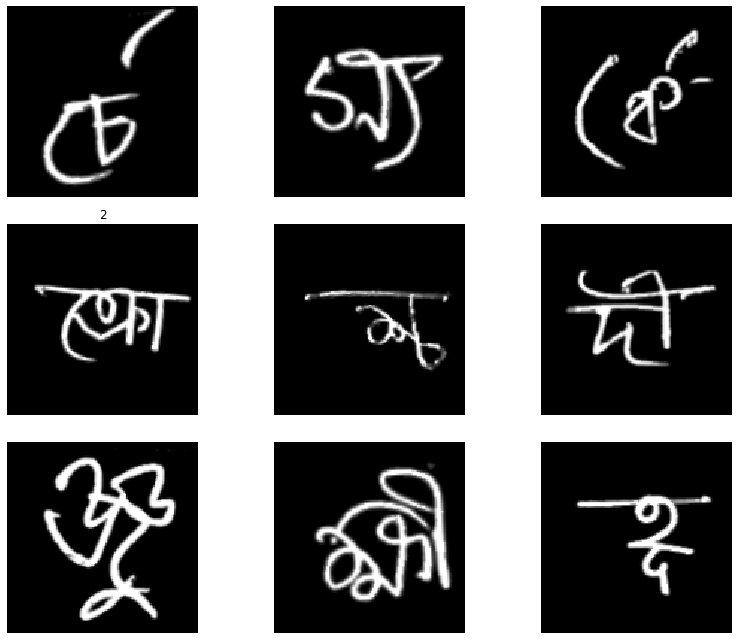

In [144]:
data.show_batch(rows=3, figsize=(12,9))
# data.label_list.y

In [118]:
??accuracy_thresh

To create a `Learner` we use the same function as in lesson 1. Our base architecture is resnet50 again, but the metrics are a little bit differeent: we use `accuracy_thresh` instead of `accuracy`. In lesson 1, we determined the predicition for a given class by picking the final activation that was the biggest, but here, each activation can be 0. or 1. `accuracy_thresh` selects the ones that are above a certain threshold (0.5 by default) and compares them to the ground truth.

As for Fbeta, it's the metric that was used by Kaggle on this competition. See [here](https://en.wikipedia.org/wiki/F1_score) for more details.

In [145]:
class Loss_combine(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, input, target):
        x1,x2,x3 = input
        y = target.long()
        return 2.0*F.cross_entropy(x1,y[:,0]) + F.cross_entropy(x2,y[:,1]) + \
          F.cross_entropy(x3,y[:,2])

In [146]:
arch = models.resnet50

In [147]:
doc(cnn_learner)

In [148]:
acc_02 = partial(accuracy_thresh, thresh=0.2)
f_score = partial(fbeta, thresh=0.2)
learn = cnn_learner(data, arch,loss_func=Loss_combine())

We use the LR Finder to pick a good learning rate.

In [149]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


ValueError: too many values to unpack (expected 3)

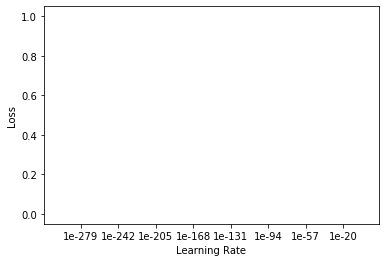

In [150]:
learn.recorder.plot()

Then we can fit the head of our network.

In [32]:
lr = 0.02

In [33]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.014995,0.012658,0.995248,0.587747,04:56


KeyboardInterrupt: 

In [ ]:
learn.save('stage-1-rn50')

...And fine-tune the whole model:

In [ ]:
learn.unfreeze()

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(5, slice(1e-6, lr/5))

In [ ]:
learn.save('stage-2-rn50')

In [ ]:
data = (src.transform(tfms, size=256)
        .databunch(bs=32).normalize(imagenet_stats))

learn.data = data
data.train_ds[0][0].shape

In [ ]:
learn.freeze()

In [ ]:
# learn.lr_find()
learn.recorder.plot()

In [ ]:
lr=1e-6/2

In [ ]:
learn.fit_one_cycle(2, slice(lr))

In [ ]:
learn.load('stage-1-256-rn50')

In [ ]:
learn.unfreeze()

In [ ]:
learn.fit_one_cycle(5, slice(1e-5, lr/5))

In [ ]:
learn.recorder.plot_losses()

In [ ]:
learn.save('stage-2-256-rn50')

You won't really know how you're going until you submit to Kaggle, since the leaderboard isn't using the same subset as we have for training. But as a guide, 50th place (out of 938 teams) on the private leaderboard was a score of `0.930`.

In [ ]:
learn.export()

## fin

(This section will be covered in part 2 - please don't ask about it just yet! :) )

In [ ]:
#! kaggle competitions download -c planet-understanding-the-amazon-from-space -f test-jpg.tar.7z -p {path}  
#! 7za -bd -y -so x {path}/test-jpg.tar.7z | tar xf - -C {path}
#! kaggle competitions download -c planet-understanding-the-amazon-from-space -f test-jpg-additional.tar.7z -p {path}  
#! 7za -bd -y -so x {path}/test-jpg-additional.tar.7z | tar xf - -C {path}

In [ ]:
test = ImageList.from_folder(path/'test-jpg').add(ImageList.from_folder(path/'test-jpg-additional'))
len(test)

In [ ]:
learn = load_learner(path, test=test)
preds, _ = learn.get_preds(ds_type=DatasetType.Test)

In [ ]:
thresh = 0.2
labelled_preds = [' '.join([learn.data.classes[i] for i,p in enumerate(pred) if p > thresh]) for pred in preds]

In [ ]:
labelled_preds[:5]

In [ ]:
fnames = [f.name[:-4] for f in learn.data.test_ds.items]

In [ ]:
df = pd.DataFrame({'image_name':fnames, 'tags':labelled_preds}, columns=['image_name', 'tags'])

In [ ]:
df.to_csv(path/'submission.csv', index=False)

In [ ]:
! kaggle competitions submit planet-understanding-the-amazon-from-space -f {path/'submission.csv'} -m "My submission"

Private Leaderboard score: 0.9296 (around 80th)